# Retrieving and Aggregating AORC Data at a Point

**Authors:** 

<ul style="line-height:1.5;">
<li>Ayman Nassar <a href="mailto:ayman.nassar@usu.edu">(ayman.nassar@usu.edu)</a></li>
<li>Pabitra Dash <a href="mailto:pabitra.dash@usu.edu">(pabitra.dash@usu.edu)</a></li>
<li>Homa Salehabadi <a href="mailto:homa.salehabadi@usu.edu">(homa.salehabadi@usu.edu)</a></li>
<li>David Tarboton <a href="mailto:david.tarboton@usu.edu">(david.tarboton@usu.edu)</a></li>
<li>Anthony Castronova <a href="acastronova@cuahsi.org">(acastronova@cuahsi.org)</a></li>

</ul>

**Last Updated:** 1/20/2025

**Purpose:**

This notebook provides code examples for retrieving NOAA Analysis of Record for Calibration (AORC) data from Amazon Web Services (AWS). It is intended to make it easy for researchers to access data for a specific point specified by latitude and longitude or known geographic coordinates. It also allows for data aggregation at time scales different from the underlying NOAA data.

**Audience:**

Researchers who are familiar with Jupyter Notebooks, basic Python and basic hydrologic data analysis.

**Description:**

This notebook takes as inputs the coordinates (e.g. latitude and longitude) of a study location in any coordinate system, start and end dates for the desired study period, a variable name, and a preferred time aggregation interval. It then retrieves data from Amazon Web Services (AWS), aggregates it over the specified time interval, displays the data as a plot, and saves it as a comma separated variable (CSV) file.

**Data Description:**

This notebook uses AORC data developed and published by NOAA on Amazon Web Services (AWS) as described in detail in this registry of open data entry <https://registry.opendata.aws/noaa-nws-aorc/>. The AORC dataset is a gridded record of near-surface weather conditions covering the continental United States and Alaska and their hydrologically contributing areas. It is defined on a latitude/longitude spatial grid with a mesh length of 30 arc seconds (~800 m), and a temporal resolution of one hour. This notebook uses the Zarr format files of version 1.1 of the AORC data. Zarr is a format for storage of chunked, compressed, N-dimensional arrays, designed to support storage using distributed systems such as cloud object stores (<https://zarr.dev/>).


**Software Requirements:**

This notebook has been tested using Python v3.11.8 using the following library versions:

 >  numpy: 1.26.4  
    geopandas: 0.14.4  
    matplotlib: 3.8.3  
    xarray: 2024.3.0  
    s3fs: 2024.3.1  
    fsspec: 2024.3.1  
    contextily: 1.6.2  
    zarr: 2.17.2  

It also uses code from aorc_utils.py that accompanies this notebook.

### 1. Prepare the Python Environment

Use the following command to ensure that all dependencies are installed in your environment. Note, these library versions have been pinned and tested for `Python 3.11.8`. Install and import the libraries needed for this notebook.

In [3]:
# note: this cell can be skipped if the dependencies have already been installed.
!pip install -r requirements.txt

In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx 
import matplotlib.pyplot as plt
from shapely.geometry import Point
from aorc_utils import (get_conus_bucket_url, load_dataset,
                        reproject_coordinates, get_variable_code,
                        get_aggregation_code, get_time_code)

### 2. Set Inputs

Set values that specify which data to retrieve. The coordinate system for the point latitude (`y`) and longitude (`x`) coordinates must be specified using European Petroleum Survey Group (EPSG) code.  EPSG codes are a widely used coordinate system encoding and can be found at [https://spatialreference.org/](https://spatialreference.org/). The specific EPSG value of 4326 given in the cell below references the World Geodetic System of 1984 (WGS84) geographic latitude and longitude coordinate system. Thus the input `lon` and `lat` values are interpreted as being in this coordinate system. If your data is in a different coordinate system, you need to look up its EPSG code at the website above and use it in the cell below.  To learn more about coordinate systems, see, for example, the [UCGIS body of Knowledge section on Coordinate Systems](https://gistbok-topics.ucgis.org/DM-05-047).


Additionally, the following variables can be retrieved from the AORC dataset.

|Common Name|Variable Name|Description|
|---|---|---|
|Total Precipitation| APCP_surface | Hourly total precipitation (kgm-2 or mm) |
|Air Temperature| TMP_2maboveground | Temperature (at 2 m above-ground-level (AGL)) (K) |
|Specific Humidity| SPFH_2maboveground | Specific humidity (at 2 m AGL) (g g-1) |
|Downward Long-Wave Radiation Flux| DLWRF_surface | longwave (infrared) radiation flux (at the surface) (W m-2) |
|Downward Short-Wave Radiation Flux| DSWRF_surface | Downward shortwave (solar) radiation flux (at the surface) (W m-2) |
|Pressure| PRES_surface | Air pressure (at the surface) (Pa) |
|U-Component of Wind| UGRD_10maboveground) | (west to east) - components of the wind (at 10 m AGL) (m s-1) |
|V-Component of Wind| VGRD_10maboveground) | (south to north) - components of the wind (at 10 m AGL) (m s-1)|

In [6]:
# Start date - In Year-Month-Day format, the earliest start date can be '1979-02-01'
start_datetime = '1990-01-01'

# End date - In Year-Month-Day format, the latest end date can be '2023-01-31'
end_datetime = '1990-12-31'

# Coordinate system EPSG code (from https://spatialreference.org/).
input_crs = 'EPSG:4326'

# Point location
# lon, lat are used as names, even for projected coordinate systems where lon = x and lat = y
lon = -111.96503  
lat = 40.77069  

# User-defined variable - see above for a list of valid variable names
variable_name = 'Total Precipitation'

# User-defined aggregation interval - valid values are 'hour','day','month','year'  
agg_interval = 'day'

### 3. Display Map with Point Location

Render a simple map to illustrate our study area. This is done by first plotting the `lat`,`lon` point defined above using the `GeoPandas` library, and then adding a basemap using the `Contextily` library. This is a quick way to add context for our analysis.

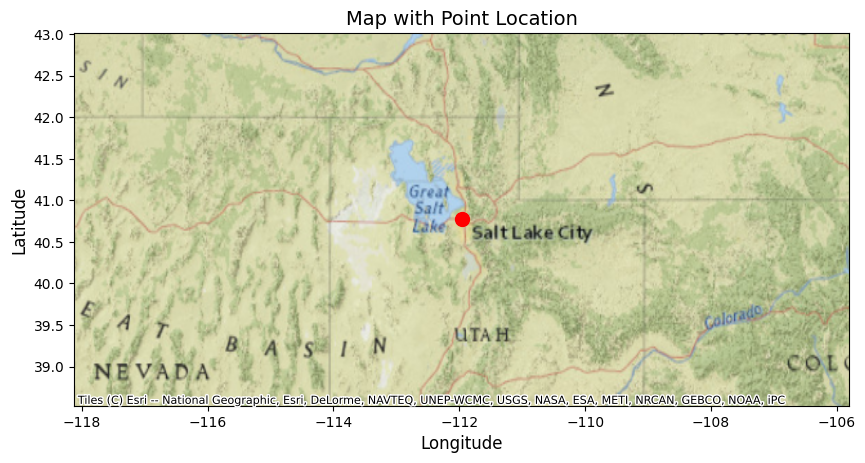

In [7]:
# Point location
point = Point(lon, lat)

# Create a GeoDataFrame with the point
gdf_point = gpd.GeoDataFrame(geometry=[point], crs=input_crs)

# Create a layout for the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Display the point location
gdf_point.plot(ax=ax, color='red', marker='o', markersize=100, label='Point Location')

# Add a topographic basemap using contextily 
ctx.add_basemap(ax,
                source=ctx.providers.Esri.NatGeoWorldMap,
                crs=gdf_point.crs.to_string(),
                alpha=1)

# Customize x and y axis labels
ax.set_title("Map with Point Location", fontsize=14)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Show the plot
plt.show()

### 4. Virtually Load the Data Array 

The AORC dataset is very large, which makes it infeasible to download and load it in entirety. Therefore, we'll use the `Xarray` library to "lazily" load it into memory. This works by reading a minimal set of metadata that will enable us to define analysis operations. The AORC dataset that we'll be loading is in the Zarr format and is hosted on Amazon S3: `s3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr/`. The following code will load these data into an `Xarray` DataSet which we can then use to subset and aggregate the data.

In [8]:
# Get the variable code
variable_code = get_variable_code(variable_name)

# Get the S3 bucket data file URL
url = get_conus_bucket_url(variable_code)
ds = load_dataset(url)

# Print the units of the selected variable in AORC dataset
print(f"The unit of {list(ds.data_vars)[0]} is {ds[list(ds.data_vars)[0]].attrs.get('units', 'No units specified')}")

# Print the dataset (ds) of selected variable
ds

The unit of RAINRATE is mm s^-1


<xarray.Dataset> Size: 27TB
Dimensions:   (time: 385704, y: 3840, x: 4608)
Coordinates:
  * time      (time) datetime64[ns] 3MB 1979-02-01 ... 2023-01-31T23:00:00
  * x         (x) float64 37kB -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y         (y) float64 31kB -1.92e+06 -1.919e+06 ... 1.918e+06 1.919e+06
Data variables:
    RAINRATE  (time, y, x) float32 27TB ...
    crs       |S1 1B ...
Attributes:
    NWM_version_number:   v2.1
    model_configuration:  AORC
    model_output_type:    forcing

### 5. Subset and Aggregate the Data

If we want to work with a portion of these data, we'll need to isolate the section of it that we're interested in. This can be done by performing a spatial subsetting operation using the `lat` and `lon` variables we defined earlier. First, we need to convert our `lat` and `lon` values into the coordinate system used by the AORC data which is the Lambert Conformal Conic projection used by the National Water Model. This can be found in the attributes of the `DataSet` we loaded above. Curious users could examine `esri_pe_string` for see details. 

In [37]:
print('-' * 52 )
print('| Attributes associated with the RAINRATE variable |')
print('-' * 52 )
for k, v in ds.RAINRATE.attrs.items():
    print(f'\n{k} -> {v}')

----------------------------------------------------
| Attributes associated with the RAINRATE variable |
----------------------------------------------------

cell_methods -> time: mean

esri_pe_string -> PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_Sphere",DATUM["D_Sphere",SPHEROID["Sphere",6370000.0,0.0]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["false_easting",0.0],PARAMETER["false_northing",0.0],PARAMETER["central_meridian",-97.0],PARAMETER["standard_parallel_1",30.0],PARAMETER["standard_parallel_2",60.0],PARAMETER["latitude_of_origin",40.0],UNIT["Meter",1.0]];-35691800 -29075200 10000;-100000 10000;-100000 10000;0.001;0.001;0.001;IsHighPrecision

grid_mapping -> crs

long_name -> Surface Precipitation Rate

proj4 -> +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=30.0 +lat_2=60.0 +lat_0=40.0 +lon_0=-97.0 +x_0=0 +y_0=0 +k_0=1.0 +nadgrids=@null +wktext  +no_defs 

remap -> remapped via ESMF regrid_with_weight

We can retrieve data for an AORC grid cell with center nearest to the point of interest. The data associated with this cell can then be aggregated temporally. The results are saved in a data frame `df_subset` which holds as columns time (date), x and y coordinates of the AORC grid cell center nearest to the input point (in the Lambert Conformal Conic coordinate system used by AORC) and the variable of interest. 

In [45]:
# Reproject coordinates
x, y = reproject_coordinates(ds, lon, lat, input_crs)

# Get aggregation code
agg_code = get_aggregation_code(agg_interval)

# Subsetting and aggregating the user-defined variable
variable_code_cap = variable_code.upper()

if variable_code == 'precip':
    ds_subset = (
        ds['RAINRATE']
          .loc[dict(time=slice(start_datetime, end_datetime))]              # slice the data temporally 
          .sel(y=y, x=x, method='nearest')                                  # select the cell nearest an x and y
          .compute() * 3600                                                 # retrieve the data and then perform unit conv                                   
    )
    df_subset = ds_subset.resample(time=agg_code).sum().to_dataframe()      # compute total rainfall per day
    unit = f"mm/{agg_interval}"
else:
    ds_subset = (
        ds[variable_code_cap]
          .loc[dict(time=slice(start_datetime, end_datetime))]              # slice the data temporally 
          .sel(y=y, x=x, method='nearest').compute()                        # select the cell nearest an x and y, retrieve the data
    )
    ds_subset_df = ds_subset.resample(time=agg_code).mean().to_dataframe()  # compute mean
    unit = ds[variable_code_cap].attrs.get('units', 'No units specified')

Rename the column corresponding with the variable we aggregated above to include units.

In [46]:
# Rename the last column to include the unit
df_subset.rename(columns={df_subset.columns[-1]: f"{df_subset.columns[-1]} ({unit})"}, inplace=True)

df_subset

,x,y,RAINRATE (mm/day)
time,,,
1990-01-01,-1214499.125,196499.65625,0.000000
1990-01-02,-1214499.125,196499.65625,3.808179
1990-01-03,-1214499.125,196499.65625,0.000000
1990-01-04,-1214499.125,196499.65625,0.000000
1990-01-05,-1214499.125,196499.65625,0.200000
...,...,...,...
1990-12-27,-1214499.125,196499.65625,0.000000
1990-12-28,-1214499.125,196499.65625,0.000000
1990-12-29,-1214499.125,196499.65625,0.000000


### 6. Plot the Data and Trend

Plot the variable that was computed above with `time` on the x-axis and add a trend line.

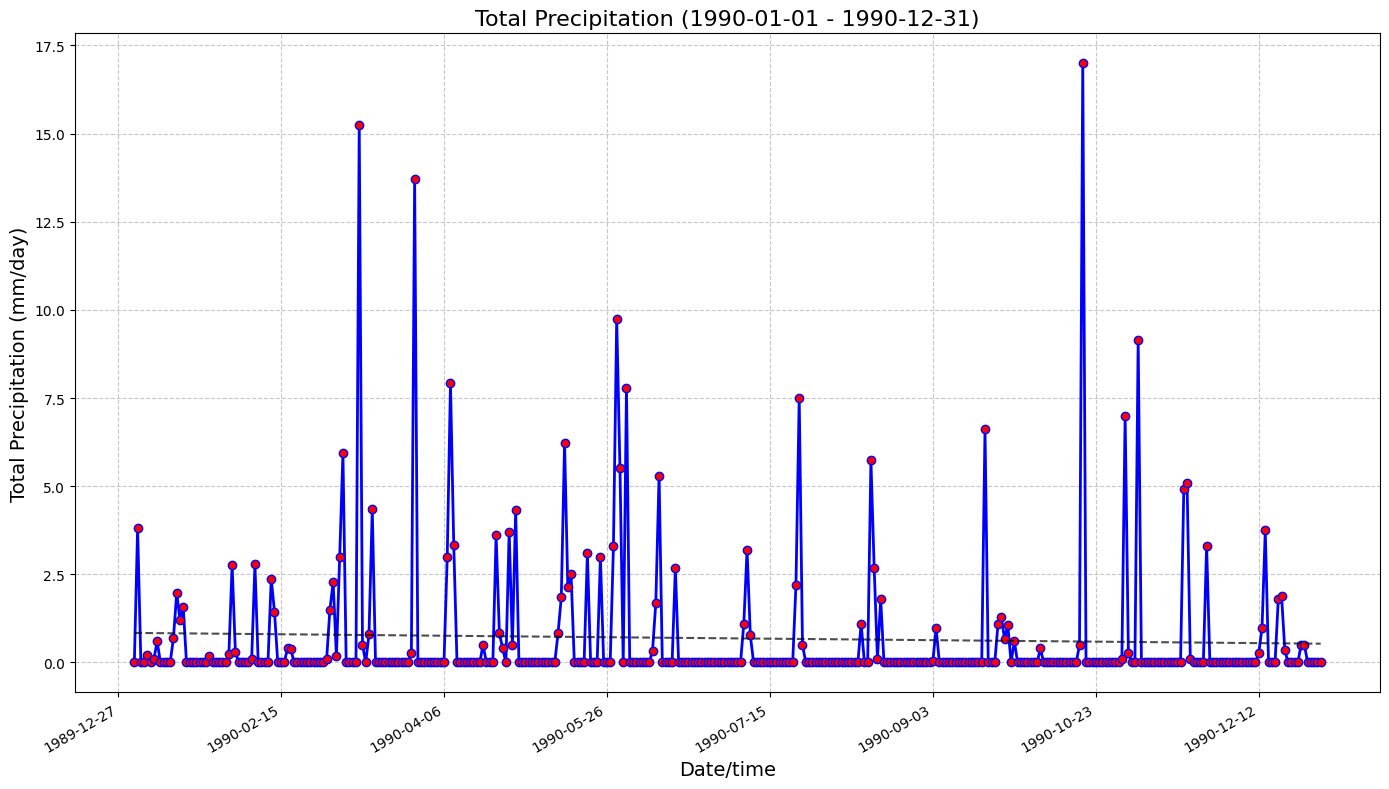

In [47]:
# Extracting the time index and column to plot
time_list=pd.to_datetime(df_subset.index)
data_list = df_subset.iloc[:, 2]

# Setup the plot
plt.figure(figsize=(14, 8))  # Adjusting the size to provide more space for x-labels
plt.plot(time_list, data_list, color='blue', linewidth=2, marker='o', markersize=6, markerfacecolor='red', markeredgewidth=1)
plt.title(f'{variable_name} ({start_datetime[:]} - {end_datetime[:]})', fontsize=16)
plt.xlabel(f'Date/time', fontsize=14)
plt.ylabel(f'{variable_name} ({unit})', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Handling overlapping x-labels
plt.xticks(rotation=45, ha='right')                           # Rotate labels and align them to the right
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))  # Show fewer labels to avoid overlap
plt.gcf().autofmt_xdate()                                     # Automatically adjust x-label formatting for better spacing

# Adding a trend line
z = np.polyfit(range(len(time_list)), data_list, 1)
p = np.poly1d(z)
plt.plot(time_list, p(range(len(time_list))), color='black', linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Saving the plot
plt.savefig(f'{agg_interval}_{variable_code}_plot_for_point.png', dpi=800)

# Displaying the plot
plt.show()


### 7. Save the Data as a CSV File

In [48]:
# Specify the file path where you want to save the CSV file
file_path = f"{variable_name}_at_a_point.csv"

# Save the DataFrame to a CSV file
df_subset.to_csv(file_path, index=True)